In [1]:
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchinfo import summary
from torch.utils.data import DataLoader

In [3]:
## GPU check
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
## 파이토치 난수 고정
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [5]:
## 이미지와 라벨 표시
def show_images_labels(loader, classes, net, device):

    # 데이터로더에서 처음 1세트를 가져오기
    for images, labels in loader:
        break

    # 표시 수는 50개
    n_size = min(len(images), 50)

    if net is not None:
      # 디바이스 할당
      inputs = images.to(device)
      labels = labels.to(device)

      # 예측 계산
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 처음 n_size개 표시
    plt.figure(figsize=(20, 15))
    
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]

        # net이 None이 아닌 경우는 예측 결과도 타이틀에 표시함
        if net is not None:
          predicted_name = classes[predicted[i]]

          # 정답인지 아닌지 색으로 구분함
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        
        # net이 None인 경우는 정답 라벨만 표시
        else:
          ax.set_title(label_name, fontsize=20)
        
        # 텐서를 넘파이로 변환
        image_np = images[i].numpy().copy()
        
        # 축의 순서 변경 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        
        # 값의 범위를[-1, 1] -> [0, 1]로 되돌림
        img = (img + 1)/2
        
        # 결과 표시
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [6]:
## 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdm 라이브러리 임포트
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs + base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 훈련 페이즈
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 경사 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 경사 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            train_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        # 예측 페이즈
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            val_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch + 1)}/{num_epochs + base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch + 1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [7]:
## 학습 로그 해석
def evaluate_history(history):
    # 손실과 정확도 확인(검증 데이터 셋 기반)
    print(f'Initial state : Loss : {history[0,3]:.5f}  Acc : {history[0,4]:.5f}') 
    print(f'Final state : Loss : {history[-1,3]:.5f}  Acc : {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 학습 곡선 출력(손실)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='train')
    plt.plot(history[:,0], history[:,3], 'k', label='val')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Curve(Loss)')
    plt.legend()
    plt.show()

    # 학습 곡선 출력(정확도)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='train')
    plt.plot(history[:,0], history[:,4], 'k', label='val')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.title('Training Curve(Acc)')
    plt.legend()
    plt.show()

In [8]:
## 데이터 준비(Dataset, Transformers)

'''
- CIFAR-10은 32 x 32 크기의 60000개의 이미지로 이루어져 있다.
- 10개의 클래스로 분류(airplane, bird, cat ...) 되며 각각의 클래스는 6000개의 이미지로 이루어져 있다.
- 6000개의 이미지는 5000개는 학습 데이터 나머지 1000개는 테스트 데이터이다.
- 총 50000개의 학습 데이터, 10000개의 테스트 데이터가 된다.
'''

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

data_root = './data'

# 훈련 데이터셋
train_set = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform = transform
)

# 검증 데이터셋
test_set = datasets.CIFAR10(
    root=data_root,
    train=False,
    download=True,
    transform = transform
)

image, label = train_set[0]
print(image.shape)
print(label)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
torch.Size([3, 32, 32])
6


In [9]:
## 데이터로더 정의

# 미니 배치 사이즈 지정
batch_size = 100

# 학습용 데이터로더 
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# 검증용 데이터로더
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [10]:
## train_loader에서 한 세트 가져오기

for images, labels in train_loader:
  break

print(images.shape)
print(labels.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100])


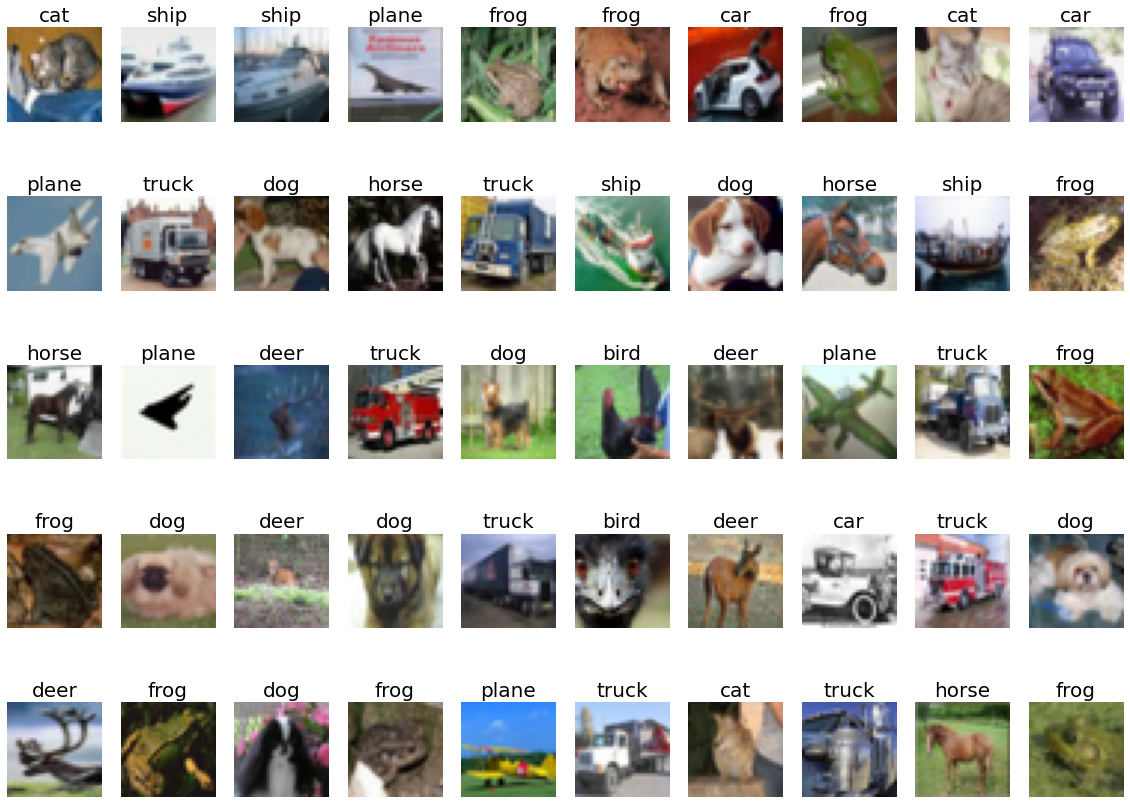

In [11]:
## 정답 라벨 정의
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 검증 데이터의 처음 50개를 출력
show_images_labels(test_loader, classes, None, None)

In [12]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3     

In [13]:
## 하이퍼파라미터 정의

# 난수 초기화
torch_seed()

# 출력 차원수
# 분류 클래스의 수이므로 10
n_output = 10

# 은닉층의 노드수
n_hidden = 128

# 반복 횟수
num_epochs = 50

# 학습률
lr = 0.01

In [14]:
## 모델 학습요소 정의

# 모델 인스턴스 생성
net = CNN(n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 평가 결과 기록
history = np.zeros((0,5))

In [15]:
## 모델 정보 확인(1)
print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [16]:
## 모델 정보 확인(2)
# summary(net, (100, 3, 32, 32), depth=1)

In [17]:
## 학습
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.02082 acc: 0.26116 val_loss: 0.01866, val_acc: 0.34740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01781 acc: 0.37304 val_loss: 0.01677, val_acc: 0.40830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01613 acc: 0.43044 val_loss: 0.01530, val_acc: 0.46070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01485 acc: 0.47334 val_loss: 0.01449, val_acc: 0.48890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01408 acc: 0.49980 val_loss: 0.01370, val_acc: 0.51320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01350 acc: 0.52136 val_loss: 0.01333, val_acc: 0.52660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01304 acc: 0.53694 val_loss: 0.01293, val_acc: 0.53770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01253 acc: 0.55460 val_loss: 0.01255, val_acc: 0.55250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01205 acc: 0.57456 val_loss: 0.01237, val_acc: 0.56050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01158 acc: 0.59106 val_loss: 0.01185, val_acc: 0.58070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01116 acc: 0.60776 val_loss: 0.01166, val_acc: 0.58790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01077 acc: 0.62298 val_loss: 0.01172, val_acc: 0.58450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01036 acc: 0.63632 val_loss: 0.01112, val_acc: 0.60590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.00997 acc: 0.64966 val_loss: 0.01091, val_acc: 0.61160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00959 acc: 0.66432 val_loss: 0.01112, val_acc: 0.60380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00922 acc: 0.67684 val_loss: 0.01054, val_acc: 0.63050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00882 acc: 0.69196 val_loss: 0.01061, val_acc: 0.62670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.00846 acc: 0.70412 val_loss: 0.01011, val_acc: 0.64800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00808 acc: 0.71820 val_loss: 0.01019, val_acc: 0.64360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00773 acc: 0.73154 val_loss: 0.01051, val_acc: 0.63300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00738 acc: 0.74216 val_loss: 0.01001, val_acc: 0.65490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00701 acc: 0.75808 val_loss: 0.01019, val_acc: 0.65410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00674 acc: 0.76582 val_loss: 0.00995, val_acc: 0.65870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00637 acc: 0.78038 val_loss: 0.01006, val_acc: 0.66030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00604 acc: 0.79274 val_loss: 0.00999, val_acc: 0.66740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00568 acc: 0.80566 val_loss: 0.01044, val_acc: 0.64880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00541 acc: 0.81520 val_loss: 0.01056, val_acc: 0.66300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00508 acc: 0.82778 val_loss: 0.01110, val_acc: 0.64590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00473 acc: 0.83954 val_loss: 0.01061, val_acc: 0.66050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00442 acc: 0.85222 val_loss: 0.01091, val_acc: 0.66110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00409 acc: 0.86252 val_loss: 0.01104, val_acc: 0.66210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00381 acc: 0.87136 val_loss: 0.01139, val_acc: 0.65800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00353 acc: 0.88318 val_loss: 0.01119, val_acc: 0.66620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00325 acc: 0.89216 val_loss: 0.01215, val_acc: 0.65540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00295 acc: 0.90460 val_loss: 0.01262, val_acc: 0.65230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00271 acc: 0.91274 val_loss: 0.01276, val_acc: 0.65070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00241 acc: 0.92488 val_loss: 0.01267, val_acc: 0.66610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00217 acc: 0.93342 val_loss: 0.01307, val_acc: 0.66340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00192 acc: 0.94204 val_loss: 0.01382, val_acc: 0.65720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00175 acc: 0.95082 val_loss: 0.01441, val_acc: 0.65360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00149 acc: 0.95824 val_loss: 0.01538, val_acc: 0.65160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00130 acc: 0.96470 val_loss: 0.01594, val_acc: 0.64200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00106 acc: 0.97530 val_loss: 0.01540, val_acc: 0.65950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00094 acc: 0.97912 val_loss: 0.01599, val_acc: 0.65560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00089 acc: 0.98110 val_loss: 0.01630, val_acc: 0.66230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00065 acc: 0.98894 val_loss: 0.01703, val_acc: 0.65350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00047 acc: 0.99408 val_loss: 0.01720, val_acc: 0.66020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00036 acc: 0.99684 val_loss: 0.01773, val_acc: 0.66110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00029 acc: 0.99770 val_loss: 0.01844, val_acc: 0.66230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00025 acc: 0.99832 val_loss: 0.01863, val_acc: 0.66380


Initial state : Loss : 0.01866  Acc : 0.34740
Final state : Loss : 0.01863  Acc : 0.66380


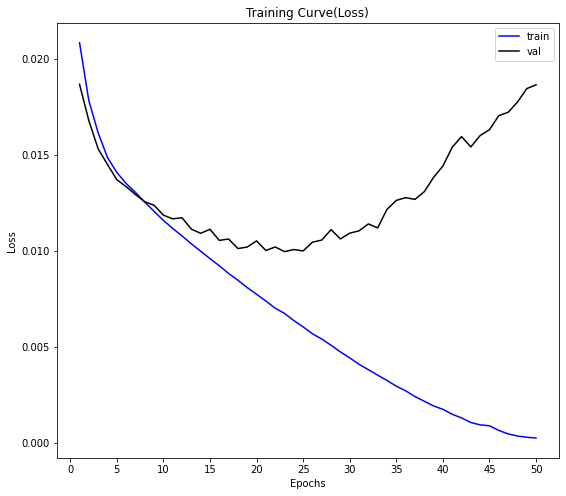

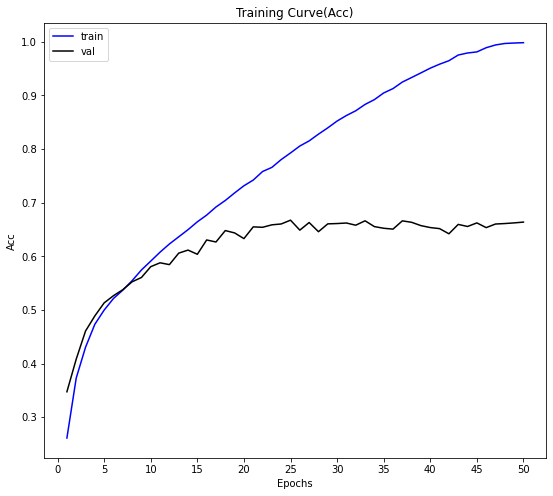

In [18]:
## 평가
evaluate_history(history)

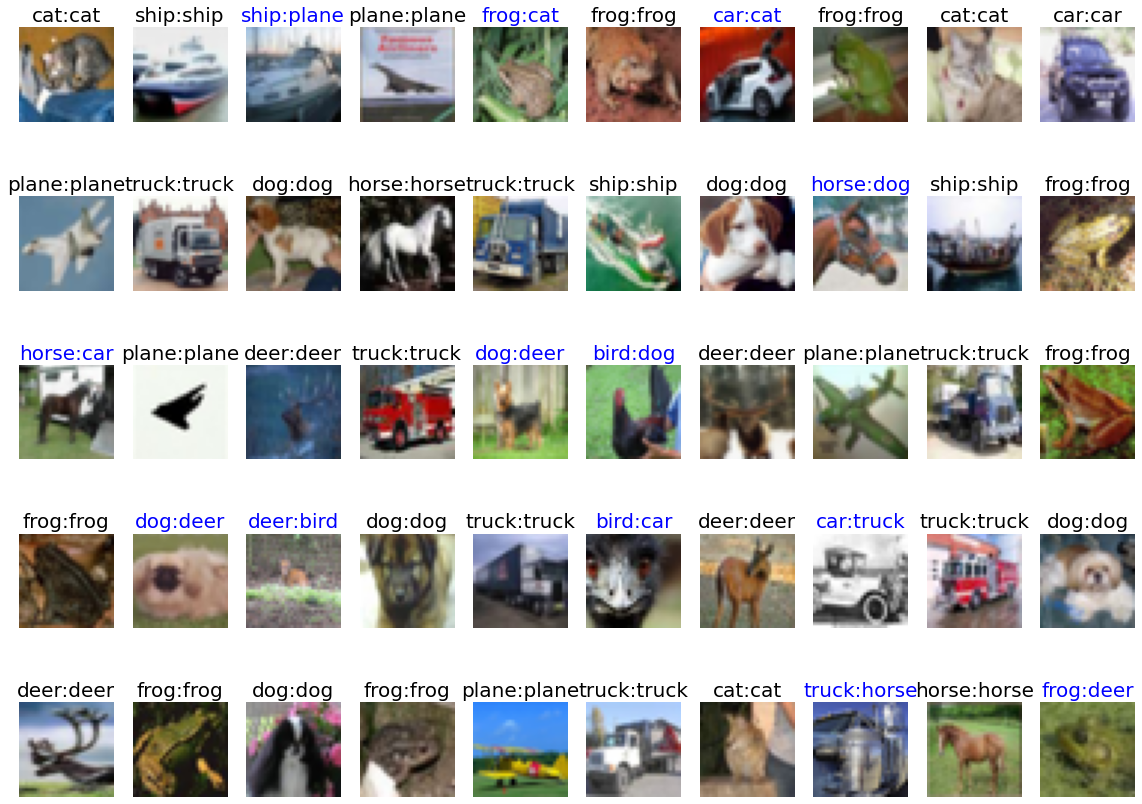

In [19]:
## 검증결과 (처음 50개 데이터 표시)
show_images_labels(test_loader, classes, net, device)